---

# <center> GFootball Stable-Baselines3 </center>

---
<center><img src="https://raw.githubusercontent.com/DLR-RM/stable-baselines3/master/docs/_static/img/logo.png" width="308" height="268" alt="Stable-Baselines3"></center>
<center><small>Image from Stable-Baselines3 repository</small></center>

---
This notebook uses the [Stable-Baselines3](https://github.com/DLR-RM/stable-baselines3) library to train a [PPO](https://openai.com/blog/openai-baselines-ppo/) reinforcement learning agent on [GFootball Academy](https://github.com/google-research/football/tree/master/gfootball/scenarios) scenarios.

In [67]:
%%bash
# Install kaggle-environments
# git clone -q https://github.com/Kaggle/kaggle-environments.git
# cd kaggle-environments && pip3 install -qq . && cd ..

# Install stable-baselines3
# git clone -q https://github.com/DLR-RM/stable-baselines3.git
# cd stable-baselines3 && pip3 install -qq . && cd ..


In [68]:
# !cp "../input/gfootball-academy/visualizer.py" .

In [69]:
import os
import gym
import pickle
import numpy as np
import pandas as pd
import torch as th
from torch import nn, tensor
from collections import deque
from gym.spaces import Box, Discrete
from kaggle_environments import make
from kaggle_environments.envs.football.helpers import *
from gfootball.env import create_environment, observation_preprocessing
from stable_baselines3 import PPO
from stable_baselines3.ppo import CnnPolicy
from stable_baselines3.common import results_plotter
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from IPython.display import HTML
from visualizer import visualize
from matplotlib import pyplot as plt
%matplotlib inline

---
# Football Gym
> [Stable-Baselines3 Custom Environments](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html)<br/>
> [SEED RL Agent](https://www.kaggle.com/piotrstanczyk/gfootball-train-seed-rl-agent): stacked observations

In [70]:
class FootballGym(gym.Env):
    spec = None
    metadata = None
    
    def __init__(self, config=None):
        super(FootballGym, self).__init__()
        env_name = "academy_empty_goal_close"
        rewards = "scoring,checkpoints"
        if config is not None:
            env_name = config.get("env_name", env_name)
            rewards = config.get("rewards", rewards)
        self.env = create_environment(
            env_name=env_name,
            stacked=False,
            representation="raw",
            rewards = rewards,
            write_goal_dumps=False,
            write_full_episode_dumps=False,
            render=False,
            write_video=False,
            dump_frequency=1,
            logdir=".",
            extra_players=None,
            number_of_left_players_agent_controls=1,
            number_of_right_players_agent_controls=0)  
        self.action_space = Discrete(19)
        self.observation_space = Box(low=0, high=255, shape=(72, 96, 16), dtype=np.uint8)
        self.reward_range = (-1, 1)
        self.obs_stack = deque([], maxlen=4)
        
    def transform_obs(self, raw_obs):
        obs = raw_obs[0]
        obs = observation_preprocessing.generate_smm([obs])
        if not self.obs_stack:
            self.obs_stack.extend([obs] * 4)
        else:
            self.obs_stack.append(obs)
        obs = np.concatenate(list(self.obs_stack), axis=-1)
        obs = np.squeeze(obs)
        return obs

    def reset(self):
        self.obs_stack.clear()
        obs = self.env.reset()
        obs = self.transform_obs(obs)
        return obs
    
    def step(self, action):
        obs, reward, done, info = self.env.step([action])
        obs = self.transform_obs(obs)
        return obs, float(reward), done, info

In [71]:
scenarios = {0: "academy_empty_goal_close",
             1: "academy_empty_goal",
             2: "academy_run_to_score",
             3: "academy_run_to_score_with_keeper",
             4: "academy_pass_and_shoot_with_keeper",
             5: "academy_run_pass_and_shoot_with_keeper",
             6: "academy_3_vs_1_with_keeper",
             7: "academy_corner",
             8: "academy_counterattack_easy",
             9: "academy_counterattack_hard",
             10: "academy_single_goal_versus_lazy",
             11: "11_vs_11_kaggle"}
scenario_name = scenarios[6]

In [72]:
test_env = FootballGym({"env_name":scenario_name})
check_env(env=test_env, warn=True)

In [73]:
def make_env(config=None, rank=0):
    def _init():
        env = FootballGym(config)
        log_file = os.path.join(".", str(rank))
        env = Monitor(env, log_file, allow_early_resets=True)
        return env
    return _init

---
# PPO Model
> [Stable-Baselines3 PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)<br/>
> [Stable-Baselines3 Vectorized Environments](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html)

In [74]:
n_envs = 4
n_steps = 512
config={"env_name":scenario_name}
# train_env = SubprocVecEnv([make_env(config, rank=i) for i in range(n_envs)])
train_env = DummyVecEnv([make_env(config, rank=i) for i in range(n_envs)])
model = PPO(CnnPolicy, train_env, n_steps=n_steps, verbose=0)
# model = PPO.load("ppo_gfootball", train_env)

In [75]:
from tqdm.notebook import tqdm
class ProgressBar(BaseCallback):
    def __init__(self, verbose=0):
        super(ProgressBar, self).__init__(verbose)
        self.pbar = None

    def _on_training_start(self):
        factor = np.ceil(self.locals['total_timesteps'] / self.model.n_steps)
        n = 1
        try:
            n = len(self.training_env.envs)
        except AttributeError:
            try:
                n = len(self.training_env.remotes)
            except AttributeError:
                n = 1
        total = int(self.model.n_steps * factor / n)
        self.pbar = tqdm(total=total)

    def _on_rollout_start(self):
        self.pbar.refresh()

    def _on_step(self):
        self.pbar.update(1)
        return True

    def _on_rollout_end(self):
        self.pbar.refresh()

    def _on_training_end(self):
        self.pbar.close()
        self.pbar = None

progressbar = ProgressBar()

---
# Training
> [Stable-Baselines3 Examples](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html)

In [76]:
total_timesteps = n_steps * n_envs * 200
model.learn(total_timesteps=total_timesteps, callback=progressbar)
model.save("ppo_gfootball")

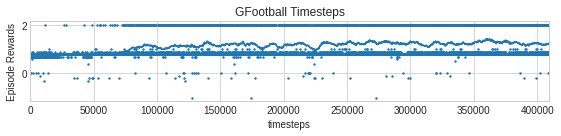

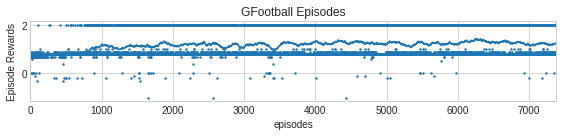

In [77]:
plt.style.use(['seaborn-whitegrid'])
results_plotter.plot_results(["."], total_timesteps, results_plotter.X_TIMESTEPS, "GFootball Timesteps")
results_plotter.plot_results(["."], total_timesteps, results_plotter.X_EPISODES, "GFootball Episodes")

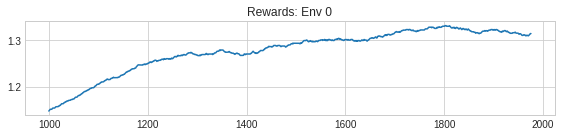

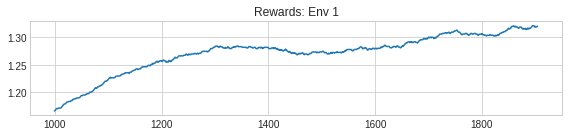

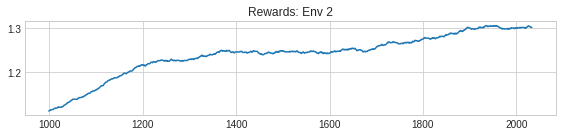

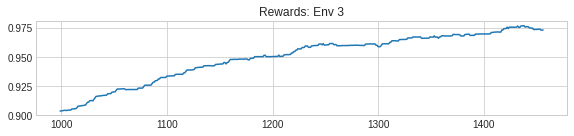

In [78]:
plt.style.use(['seaborn-whitegrid'])
log_files = [os.path.join(".", f"{i}.monitor.csv") for i in range(n_envs)]

for i, log_file in enumerate(log_files):
    if os.path.isfile(log_file):
        df = pd.read_csv(log_file, skiprows=1)
        fig = plt.figure(figsize=(8, 2))
        df['r'].rolling(window=1000).mean().plot(title=f"Rewards: Env {i}")
        plt.tight_layout()
        plt.show()

In [79]:
model = PPO.load("ppo_gfootball")
test_env = FootballGym({"env_name":scenario_name})
obs = test_env.reset()
done = False
while not done:
    action, state = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
    print(f"{Action(action).name.ljust(16,' ')}\t{round(reward,2)}\t{info}")

Right           	0.7	{'score_reward': 0}
LongPass        	0.0	{'score_reward': 0}
Bottom          	0.0	{'score_reward': 0}
HighPass        	0.1	{'score_reward': 0}
LongPass        	0.0	{'score_reward': 0}
ReleaseDirection	0.0	{'score_reward': 0}
ReleaseDribble  	0.0	{'score_reward': 0}
ReleaseDribble  	0.0	{'score_reward': 0}
Shot            	0.0	{'score_reward': 0}
BottomLeft      	0.0	{'score_reward': 0}
TopRight        	0.0	{'score_reward': 0}
Sprint          	0.0	{'score_reward': 0}
HighPass        	0.0	{'score_reward': 0}
TopLeft         	0.0	{'score_reward': 0}
Slide           	0.0	{'score_reward': 0}
TopLeft         	0.0	{'score_reward': 0}
ReleaseDribble  	0.0	{'score_reward': 0}
ReleaseDribble  	0.0	{'score_reward': 0}
ReleaseDirection	0.0	{'score_reward': 0}
Shot            	0.0	{'score_reward': 0}
BottomRight     	0.0	{'score_reward': 0}


---
# Agent
> [Stable-Baselines: Exporting Models](https://stable-baselines.readthedocs.io/en/master/guide/export.html)<br/>
> [Stable-Baselines: Converting a Model into PyTorch](https://github.com/hill-a/stable-baselines/issues/372)<br/>
> [Connect4: Make Submission with Stable-Baselines3](https://www.kaggle.com/toshikazuwatanabe/connect4-make-submission-with-stable-baselines3)

In [80]:
%%writefile submission.py
import pickle
import numpy as np
import torch as th
from torch import nn, tensor
from collections import deque
from gfootball.env import observation_preprocessing

state_dict = _STATE_DICT_

state_dict = pickle.loads(state_dict)
class PyTorchCnnPolicy(nn.Module):
    global state_dict
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=16,  out_channels=32, kernel_size=8, stride=4, padding=0, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, bias=True)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=0, bias=True)
        self.fc1 = nn.Linear(2560, 512, bias=True)
        self.fc2 = nn.Linear(512, 19)
        self.relu = nn.ReLU()
        self.out_activ = nn.Softmax(dim=1)
        self.load_state_dict(state_dict)

    def forward(self, x):
        x = tensor(x).float() / 255.0  # normalize
        x = x.permute(0, 3, 1, 2).contiguous()  # 1 x channels x height x width
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.reshape(x.shape[0], -1)  # flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.out_activ(x)
        return int(x.argmax())

obs_stack = deque([], maxlen=4)
def transform_obs(raw_obs):
    global obs_stack
    obs = raw_obs['players_raw'][0]
    obs = observation_preprocessing.generate_smm([obs])
    if not obs_stack:
        obs_stack.extend([obs] * 4)
    else:
        obs_stack.append(obs)
    obs = np.concatenate(list(obs_stack), axis=-1)
    return obs

policy = PyTorchCnnPolicy()
policy = policy.float().to('cpu').eval()
def agent(raw_obs):
    obs = transform_obs(raw_obs)
    action = policy(obs)
    return [action]

Overwriting submission.py


In [81]:
model = PPO.load("ppo_gfootball")
_state_dict = model.policy.to('cpu').state_dict()
state_dict = {
    "conv1.weight":_state_dict['features_extractor.cnn.0.weight'], 
    "conv1.bias":_state_dict['features_extractor.cnn.0.bias'], 
    "conv2.weight":_state_dict['features_extractor.cnn.2.weight'], 
    "conv2.bias":_state_dict['features_extractor.cnn.2.bias'], 
    "conv3.weight":_state_dict['features_extractor.cnn.4.weight'], 
    "conv3.bias":_state_dict['features_extractor.cnn.4.bias'], 
    "fc1.weight":_state_dict['features_extractor.linear.0.weight'], 
    "fc1.bias":_state_dict['features_extractor.linear.0.bias'], 
    "fc2.weight":_state_dict['action_net.weight'],
    "fc2.bias":_state_dict['action_net.bias'],
}
state_dict = pickle.dumps(state_dict)
with open('submission.py', 'r') as file:
    src = file.read()
src = src.replace("_STATE_DICT_", f"{state_dict}")
with open('submission.py', 'w') as file:
    file.write(src)

---
# Testing

In [82]:
kaggle_env = make("football", debug = False,
                  configuration={"scenario_name": scenario_name, 
                                 "running_in_notebook": True,
                                 "save_video": False})

In [83]:
output = kaggle_env.run(["submission.py", "do_nothing"])

In [84]:
scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))

Scores  1 : 0
Rewards 1 : -1


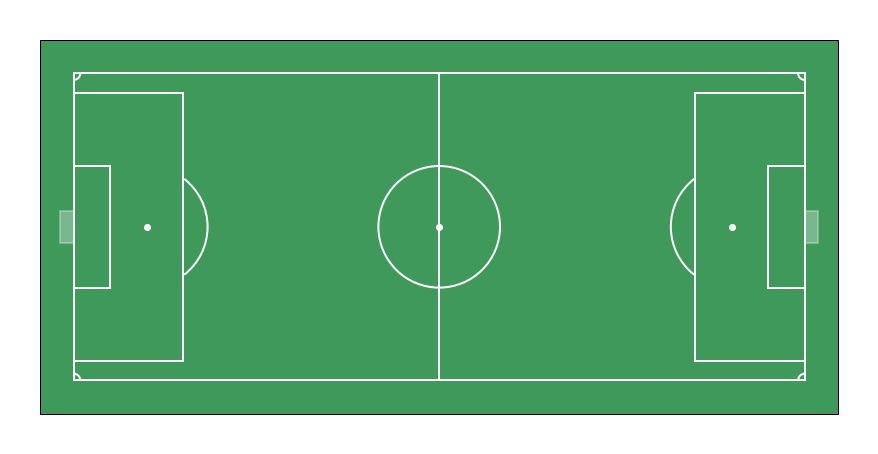

In [85]:
viz = visualize(output)

> Modified [Human Readable Visualization](https://www.kaggle.com/jaronmichal/human-readable-visualization)

In [86]:
HTML(viz.to_html5_video())

---
# Checkpoints

0. [academy_empty_goal_close @ 800K steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=45569809#Test-Agent)<br/>
1. [academy_empty_goal @ 800K steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=45639135#Test-Agent)<br/>
2. [academy_run_to_score @ 800K steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=45941674#Test-Agent)<br/>
3. [academy_run_to_score_with_keeper @ 800K steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=45703399#Test-Agent)<br/>
4. [academy_pass_and_shoot_with_keeper @ 800K steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=45716494#Test-Agent)<br/>
5. [academy_run_pass_and_shoot_with_keeper @ 1.6M steps](https://www.kaggle.com/kwabenantim/gfootball-stable-baselines3?scriptVersionId=46590578#Testing)